# Recommendations KMeans

## 💡 1. Introduction

### 1.1 The objective
With the data storage solution up and running, we have access to a lot of features including the ratings from a wide verity of critics. The objective is to find out how good KMeans clustering is for providing a set of recommendations for a specific user with a backlog of previously played games.

### 1.2 About this document
This document aims to provide a consistent testing environment where we can tweak and analyze the different hyper-parameters to see how they have an influence on predicting the recommendation score for video games. In this document I will write down all thoughts, ideas, hypotheses, and discoveries I've made along the way.

## 2. Preparations

### 2.1 Importing libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [2]:
plt.style.use('seaborn')

### 2.2 Importing datasets
The data storage solution provides us with three dataframes. We can easily import the ones we need with the use of storage magic. Storage magic is for lightweight persistence between notebooks. It stores variables, aliases, and macros in the IPython's database.

More info about storage magic can be found here:<br>
https://ipython.readthedocs.io/en/stable/config/extensions/storemagic.html

The data storage solution can be found here:<br>
https://github.com/i442124/SuperScope/tree/main/notebooks/data-extraction

In [3]:
%store -r games ratings

In [4]:
games.head()

,title,platform,publisher,genres
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,Nintendo,"[Fantasy, Action Adventure]"
1,Tony Hawk's Pro Skater 2,PlayStation,Activision,"[Skateboarding, Sports, Alternative]"
2,Grand Theft Auto IV,PlayStation 3,Rockstar Games,"[Modern, Open-World, Action Adventure]"
3,SoulCalibur,Dreamcast,Namco,"[Fighting, 3D, Action]"
4,Grand Theft Auto IV,Xbox 360,Rockstar Games,"[Modern, Open-World, Action Adventure]"


In [5]:
ratings.head()

,title,platform,meta_score,review_critic
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Hot Games
1,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,GameShark
2,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Cincinnati Enquirer
3,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Nintendophiles
4,The Legend of Zelda: Ocarina of Time,Nintendo 64,100.0,Electronic Gaming Monthly


In [6]:
print(f'The dataset contains: {len(ratings)} ratings of {len(games)} games.')

The dataset contains: 422435 ratings of 18295 games.


## 🔎3. Examination

### 3.1 Correlation between user genres
Let's start off by looking for correlations between the different genres. We can achieve this by combining the reviews dataset with the game details dataset. We pivot the dataframe so we have the critics on the Y-Axis and the genres on the X-Axis with the average score in the cell values.

In [7]:
def avg_genre_matrix(ratings):
    # Split each game into multiple rows
    # for each genre they have, this makes
    # it easier to calculate the average score
    genre_ratings = pd.merge(games, ratings)
    genre_ratings = genre_ratings.explode(column='genres')

    # Calcluate average of each review_critic of each genre
    genre_ratings = genre_ratings.groupby(['review_critic', 'genres']).mean()
    genre_ratings = genre_ratings.reset_index().pivot('review_critic', 'genres', 'meta_score')
    return genre_ratings

In [8]:
genre_ratings = avg_genre_matrix(ratings)
genre_ratings.iloc[:10, :10]

genres,2D,3D,4X,Action,Action Adventure,Action RPG,Adventure,Alternative,Application,Arcade
review_critic,,,,,,,,,,
1UP,74.919811,66.234657,86.25,68.013678,69.178503,70.718919,68.814815,66.880000,80.0,67.941423
360 Gamer Magazine UK,67.000000,60.000000,NaN,68.512397,66.578947,76.666667,60.000000,64.000000,NaN,70.350877
3DAvenue,72.800000,76.120000,NaN,77.053846,77.081967,78.090909,71.600000,72.666667,NaN,80.708333
3DJuegos,79.644699,76.094118,82.50,76.800560,77.894286,79.241877,76.370504,76.090909,70.5,76.445946
4Players.de,76.763948,71.652720,77.15,72.563559,73.653772,76.970000,73.478261,73.666667,NaN,69.732441
9Lives,80.615385,82.615385,NaN,77.835443,78.432432,79.333333,79.000000,81.000000,72.0,77.086957
Absolute Games,72.666667,67.347826,70.75,63.207071,66.804348,67.641026,63.412698,NaN,NaN,62.379845
Absolute Playstation,90.333333,87.090909,NaN,86.807692,90.315789,86.750000,NaN,79.833333,NaN,88.200000
AceGamez,77.050505,72.181818,91.25,74.171225,73.804627,72.704545,70.069307,69.848485,60.0,74.802048


We can see a few NaN values, which indicates that this reviewer has not scored a game in this genre (yet). At first glance this might not seem that important but it's possible for a reviewer to not play a certain genre, because they know that they don't like a specific genre. We can compare the scores of all critics with each other and start looking for correlations between the different genres to see if we have a pattern in the dataset.

<AxesSubplot:xlabel='genres', ylabel='genres'>

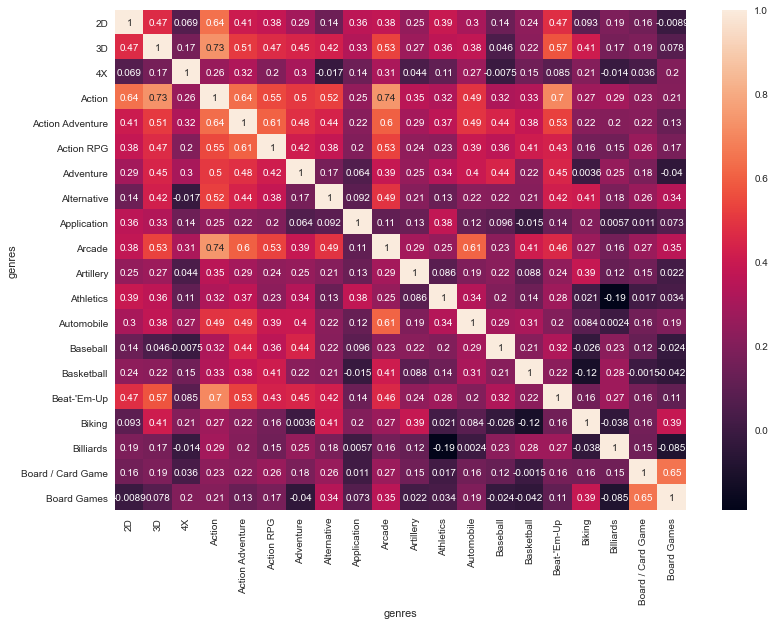

In [9]:
plt.figure(figsize=(12.8, 9.2))
sns.heatmap(genre_ratings.iloc[:, :20].corr(), annot=True)

We can see that most of the correlations are not super strong, although we do have some moderate outliers like 2D Action which seems to be very popular of a combination along with Action RPG and Action Adventure.

## 🧪4. Experimentation

## 4.1 Action vs Adventure
Now that we have the averages of all genres for each review critic and an idea of what kind correlations we have, let’s compare two of the most popular genres with each other. We can use a scatter plot where the scores of the action genre on the X axis and the adventure genre on the Y axis. Spots on the bottom left indicate that the critic doesn't like action nor adventure, while the top right indicates that the critic really loves action and adventure.

In [10]:
action_adventure = genre_ratings[['Action', 'Adventure']]
action_adventure = action_adventure[action_adventure['Action'].notna()]
action_adventure = action_adventure[action_adventure['Adventure'].notna()]

<AxesSubplot:xlabel='Action', ylabel='Adventure'>

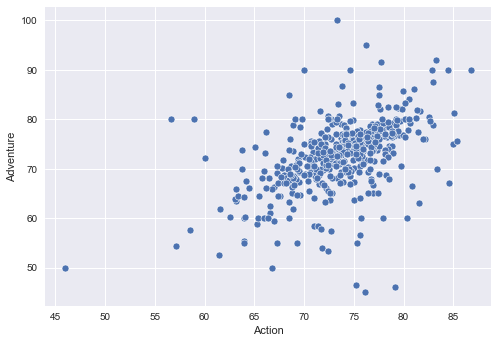

In [11]:
sns.scatterplot(data=action_adventure, x='Action', y='Adventure')

It looks like most people enjoy action adventure as the center of all points is located in the top right. Let’s check out how KMeans performs when we split these review scores into two different groups. I'd expect a segmentation somewhere around the (75,75) mark.

<AxesSubplot:xlabel='Action', ylabel='Adventure'>

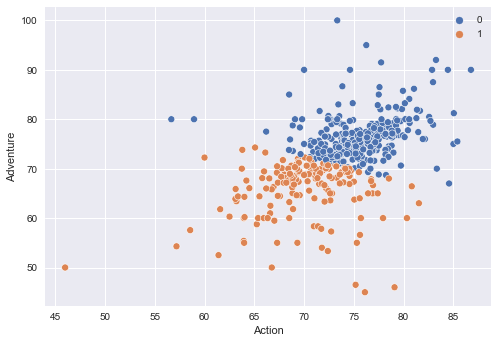

In [12]:
clusterer = KMeans(n_clusters=2)
predictions = clusterer.fit_predict(action_adventure)
sns.scatterplot(data=action_adventure, x='Action', y='Adventure', hue=predictions, palette='deep')

As expected, there is a clear segmentation right where I thought it to be. We can see that the cluster that the critic belongs to depends on if they rate adventure higher than action (or vice versa). Let’s check what happens when we increase the number of clusters.

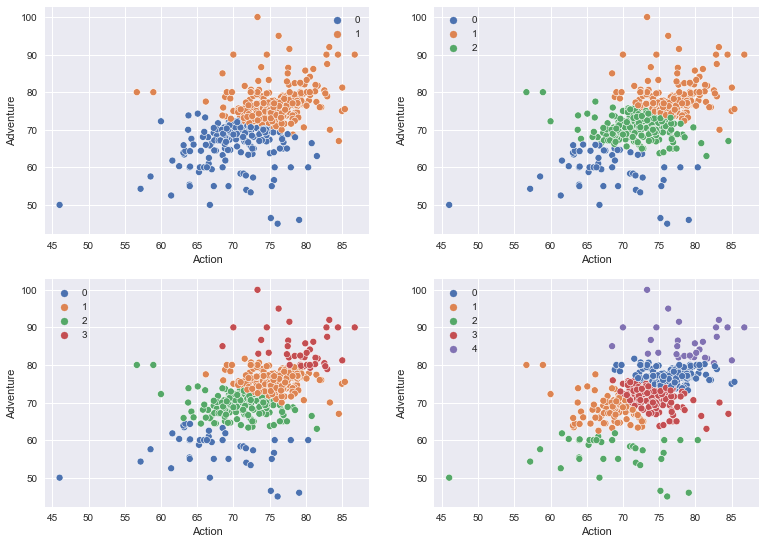

In [13]:
k_values = [2, 3, 4, 5]
fig, axs = plt.subplots(2, 2, figsize=(12.8, 9.2))

for i, k in enumerate(k_values): 
    clusterer = KMeans(n_clusters=k)
    predictions = clusterer.fit_predict(action_adventure)
    sns.scatterplot(ax=axs.ravel()[i], data=action_adventure, x='Action', y='Adventure', hue=predictions, palette='deep')

We start to see that the more clusters we add, the more similar the taste of each of the cluster blends in with the others. This is the exact effect we are looking for, but what would be the most optimal value?

### 4.2 Finding Optimal K
There are several techniques we can use to determine the optimal value of K. The most popular method for finding the optimal value is known as 'The Elbow Method'. Another method I found is known as the silhouette-method which I'd like to try out as well, to see how they compare with each other.

Useful sources: <br>
https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set<br>
https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb<br>

In [14]:
def elbow_method(k, data):
    clusterer = KMeans(n_clusters=k)
    pred = clusterer.fit_predict(data)
    return clusterer.inertia_

In [15]:
def silhouette_method(k, data):
    kmeans = KMeans(n_clusters=k)
    pred = kmeans.fit_predict(data)
    return silhouette_score(data, pred)

Let’s start off with gathering all possible k values we can go for. KMeans is limited to the number of entries/rows in the dataset, which for us is the total amount of critics we have so do keep that in mind. Let's generate a range between 2 (the minimum number of clusters) and an arbitrary number like 20.

In [16]:
possible_k_values = range(2, 20 + 1, 1)

First, we will plot the Elbow Method. The elbow method is known for ... it's elbow shape. The value we are looking for is represented by the bend of the elbow. This point should be an indication how many clusters we have in the dataset. So, let's figure out how many clusters we have in the action/adventure genre.

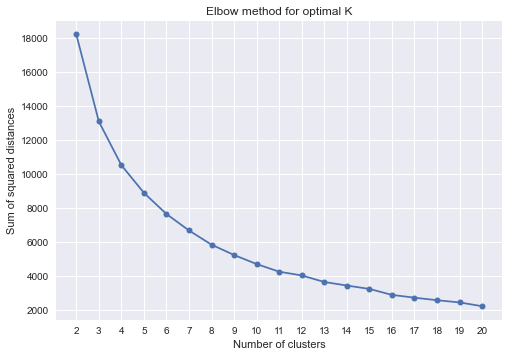

In [17]:
squared_distances = [elbow_method(k, action_adventure) for k in possible_k_values]
plt.plot(possible_k_values, squared_distances, marker='.', markersize=12)
plt.xticks(np.arange(min(possible_k_values), max(possible_k_values)+1))
plt.title('Elbow method for optimal K')
plt.ylabel('Sum of squared distances')
plt.xlabel('Number of clusters')
plt.show()

Looks like the sweet spot is roughly at 6 clusters. Let's compare this with the silhouette score. With the silhouette method we are mostly interested in the highest peak on the chart.

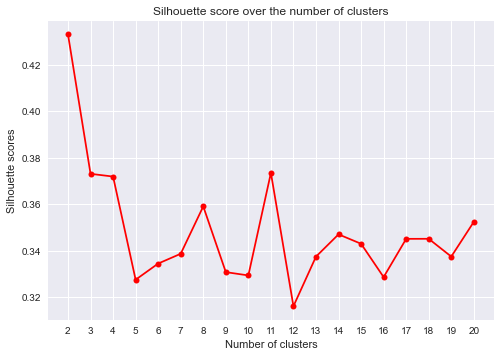

In [18]:
silhouette_scores = [silhouette_method(k, action_adventure) for k in possible_k_values]
plt.plot(possible_k_values, silhouette_scores, marker='.', markersize=12, color='red')
plt.xticks(np.arange(min(possible_k_values), max(possible_k_values)+1))
plt.title('Silhouette score over the number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette scores')
plt.show()

Whats intresting about this plot is that it's peak is already at two, which happens to be the amount of genres that we are trying to compare... Ignoring that part, 3 and 8 clusters seem like good choices as well. Any of these could be good picks so let's check them all out. Let's include the 6 clusters from the elbow method as well.

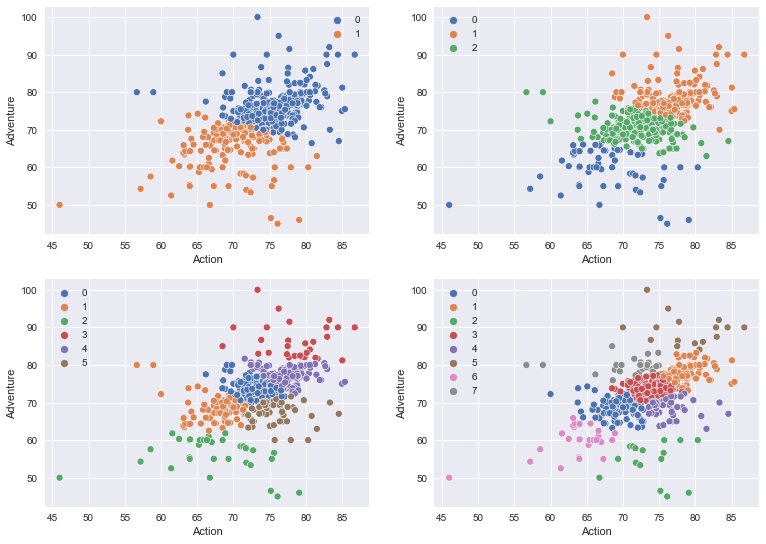

In [19]:
k_values = [2, 3, 6, 8]
fig, axs = plt.subplots(2, 2, figsize=(12.8, 9.2))

for i, k in enumerate(k_values): 
    clusterer = KMeans(n_clusters=k)
    predictions = clusterer.fit_predict(action_adventure)
    sns.scatterplot(ax=axs.ravel()[i], data=action_adventure, x='Action', y='Adventure', hue=predictions, palette='deep')

## ⚙️ 4. Settings

In [20]:
## NUBMER OF CLUSTERS THAT THE 
## REVIEWERS SHOULD BE DEVIDED INTO
K_CLUSTERS = 11

## SCORE REDUCTION STRENGTH FOR GAMES
## WITH LOWER AMOUNT OF REVIEWS IN
## THE CLUSTER
PENALIZER_STRENGTH = 1

## PLATFORMS THAT YOU WANT
## TO GET RECOMMENDATIONS FOR
SUPPORTED_PLATFORMS = ['Switch']

## MINIMUM AMOUNT OF REVIEWS
## THAT THE GAME MUST HAVE
MIN_REVIEWS_COUNT = 0

## How to resolve NaN values for 
## critics that haven't played a genre
## possible values: 'drop', 'mean', 'zeros', 'neutral' and 'kNN'
IMPUTATION_RESOLVER = 'kNN'

## MINIMUM AMOUNT OF REVIEWS THAT
## THE CRITIC MUST HAVE WRITTEN
MIN_REVIEWS_WRITTEN = 325

## SIZE OF THE TRAIN AND
## TEST RATIOS OF THE DATASET
TRAIN_TEST_RATIO = (0.7, 0.3)

## 🧮 5. User-Genre Matrix 
Now that we have confirmed that there is a correlation between the review critics and gernes and have some basic knowledge on how KMeans will operate, we can start looking at the bigger picture. Instead of comparing two genres with each other, we want to compare them all with each other and group each review critic in its own cluster.

### 5.1 Train Test Split
Before we start performing any operations, lets split the data that we have into train and test data. We are going to measure the accuracy by comparing the average score of the cluster with the actual score that the review critic has given to the game. I want to keep all the reviews of a critic in either the train data set or test dataset, so we'll need to `GroupShuffleSplit` them.

In [21]:
gss = GroupShuffleSplit(n_splits=2, train_size=TRAIN_TEST_RATIO[0], test_size=TRAIN_TEST_RATIO[1], random_state=42)

We can obtain the indices for our train and test data by calling the `split` method. When can use the index locator of the original dataframe to collect the actual train and test datasets.

In [22]:
train_idx, test_idx = next(gss.split(ratings, groups=ratings['review_critic']))
train, test = ratings.iloc[train_idx], ratings.iloc[test_idx]

### 5.2 Feature Selection
Next, let’s start with filtering some of the ratings in the dataset that we don't want/need in our training dataset. Critics that don't write enough reviews and games that don't have enough reviews should preferably be taken out of the equation, due to their inaccuracies. You can tweak these parameters in the settings section.

In [23]:
train = train[train.groupby(['review_critic'])['review_critic'].transform('size') > MIN_REVIEWS_WRITTEN]
train = train[train.groupby(['title', 'platform'])['review_critic'].transform('size') > MIN_REVIEWS_COUNT]

In [24]:
print(f"The train set contains: {len(train)} ratings of {len(train.groupby(['title', 'platform']))} games.")
print(f"The test set contains: {len(test)} ratings of {len(test.groupby(['title', 'platform']))} games.")

The train set contains: 264442 ratings of 18310 games.
The test set contains: 135333 ratings of 18188 games.


After the training set has been processed, we can start generating the average genre matrix like we did before. This time we want to include all the genres that we have available in the dataset.

In [25]:
test_matrix = avg_genre_matrix(test)
train_matrix = avg_genre_matrix(train)

### 5.3 Imputation
Next, we need to decide what to do with critics that don't provide reviews for a specific genre. KMeans operates very poorly on missing values so we need to impute values (or drop the rows all together). You can use the imputation resolver in the settings to quickly see the differences between all methods. 

Here is a brief overview of all the settings:
* `drop`: removes the row from the dataset, not recommended
* `mean`: calculates the average genre rating and fills the missing values
* `zeroes`: fills the missing values with a score of zero
* `neutral`: fills the missing values with a score of fifty
* `kNN`: fills the missing values using the KNNImputer.

In [26]:
if IMPUTATION_RESOLVER == 'drop':
    test_matrix = test_matrix.dropna()
    train_matrix = train_matrix.dropna()
elif IMPUTATION_RESOLVER == 'zeros':
    test_matrix = test_matrix.fillna(value=0)
    train_matrix = train_matrix.fillna(value=0)
elif IMPUTATION_RESOLVER == 'neutral':
    test_matrix = test_matrix.fillna(value=50)
    train_matrix = train_matrix.fillna(value=50)
elif IMPUTATION_RESOLVER == 'mean':
    test_matrix = test_matrix.fillna(test_matrix.mean())
    train_matrix = train_matrix.fillna(train_matrix.mean())
elif IMPUTATION_RESOLVER == 'kNN':
    imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    test_matrix = pd.DataFrame(imputer.fit_transform(test_matrix), columns=test_matrix.columns, index=test_matrix.index)
    train_matrix = pd.DataFrame(imputer.fit_transform(train_matrix), columns=train_matrix.columns, index=train_matrix.index)

### 5.3 Standardisation
When applying K-means clustering it's best to always standardize the data before fitting. Standardization reduces the risks of miscalculations between the distances of data. We can easily apply this by using the preprocessing library provided by sklearn.

In [27]:
SS = StandardScaler(with_mean=True, with_std=True)
scaled_test_matrix = SS.fit_transform(test_matrix)
scaled_train_matrix = SS.fit_transform(train_matrix)

## 🧠 6. KMeans Clustering

### Cheat sheet

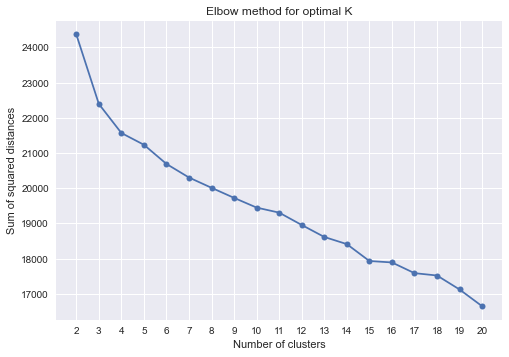

In [28]:
squared_distances = [elbow_method(k, scaled_train_matrix) for k in possible_k_values]
plt.plot(possible_k_values, squared_distances, marker='.', markersize=12)
plt.xticks(np.arange(min(possible_k_values), max(possible_k_values)+1))
plt.title('Elbow method for optimal K')
plt.ylabel('Sum of squared distances')
plt.xlabel('Number of clusters')
plt.show()

### 6.1 Training the model
We can use the cheat sheet to get an idea on the number of clusters we will need. We pass in the number of clusters that we have configured in the settings and use the constant `random_state` of 42, so the results are consistent between reruns of the script.

In [29]:
clusterer = KMeans(n_clusters=K_CLUSTERS, random_state=42)
predictions = clusterer.fit_predict(scaled_train_matrix)
predictions

array([ 4,  8,  7,  8,  1,  0,  9,  1,  4,  5,  4,  5,  8,  5,  0, 10,  2,
        4,  7,  0,  4,  8,  4,  8,  4,  5,  4,  4,  4,  8,  1,  3,  0,  8,
        5,  4,  7,  5,  3,  4,  4,  2,  4,  4,  8,  4,  6,  4,  4,  8,  1,
        8,  3,  4,  8,  4,  3,  2,  4,  4,  4,  1,  1,  8,  3,  9,  8,  0,
        4,  0,  8,  8,  0,  4,  8,  4,  4,  4,  4,  1,  3,  5,  0,  5,  5,
        8,  4,  4,  5,  4,  8,  8,  0,  8,  0,  3,  3,  4,  2,  3,  4,  4,
        0,  3,  4,  3,  4,  0,  4,  3,  0,  0,  0,  0,  0,  0,  7,  7,  3,
        4,  3,  5,  3,  3,  1,  4,  8,  8,  9,  5,  8,  4,  4,  8,  4,  3,
        5,  5,  3,  8,  3,  5,  5,  1,  3,  4,  5,  7,  4,  2,  3,  8,  2,
        4,  4,  5,  5,  3,  5,  4,  3,  5,  1,  3,  1,  1,  5,  5,  4,  3,
        8,  0,  0,  5,  8,  4,  8,  2,  8,  2,  1,  3,  0])

Let's check the distribution of critics among the clusters.

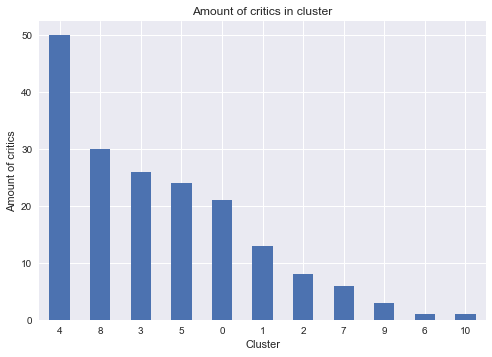

In [30]:
train_matrix['cluster'] = predictions
train_matrix['cluster'].value_counts().plot.bar()
plt.title('Amount of critics in cluster')
plt.ylabel('Amount of critics')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

And double check the amount of reviews that we can find in the dataset.

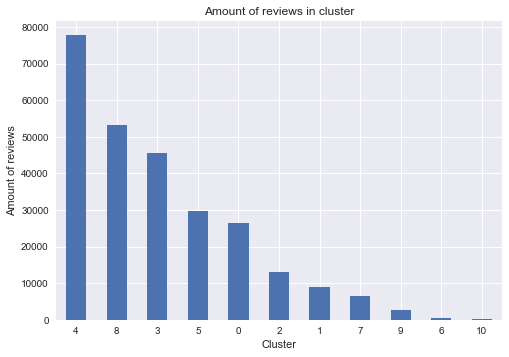

In [31]:
train = train.merge(train_matrix.reset_index()[['review_critic','cluster']])
train['cluster'].value_counts().plot.bar()
plt.title('Amount of reviews in cluster')
plt.ylabel('Amount of reviews')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

The clusters are supposed to shape themselves to a preference of the genres that the users in that cluster like. We can use a radar plot to visualize the formations the clusters have gotten to get a better understanding of what kind of 'people' can be found in what cluster.

In [32]:
radar = train_matrix.groupby('cluster').mean().reset_index()
radar.columns.name = None
radar

,cluster,2D,3D,4X,Action,Action Adventure,Action RPG,Adventure,Alternative,Application,...,Virtual,Virtual Life,Visual Novel,Volleyball,WWI,WWII,Wakeboarding,Wargame,Western-Style,Wrestling
0,0,74.413070,72.014878,80.597870,73.326811,73.334506,77.517288,70.577800,73.433934,78.464671,...,72.043303,71.893794,73.905663,66.012698,70.814286,68.891300,76.679365,68.367582,78.680478,73.112583
1,1,75.934297,72.783486,86.550272,75.087520,76.917841,77.903351,74.293143,79.526290,74.809744,...,78.647697,79.014377,77.990240,64.915385,73.538462,76.841954,80.541026,68.439487,79.117467,64.689120
2,2,66.213845,60.770870,75.436259,62.720384,63.675124,65.235347,62.273626,59.446744,64.416667,...,62.186705,64.325412,70.130809,59.862500,63.375000,61.377965,76.575000,69.925952,72.495265,53.668056
3,3,71.468630,67.771609,79.038931,68.336009,69.829239,72.259012,68.986598,66.365327,70.171154,...,67.545451,69.699375,72.746605,57.384615,69.515385,61.430216,74.474359,68.939796,76.290395,66.377478
4,4,78.564002,76.034020,85.101277,76.922730,78.343029,79.239240,75.915196,75.802282,76.941333,...,77.376615,77.688206,76.515434,65.880000,74.750000,74.921519,80.358000,78.136829,82.833881,76.760861
5,5,77.840554,73.314427,76.921702,73.947465,74.654459,75.851470,73.749916,75.883974,76.889087,...,72.860845,73.177650,75.723289,57.423611,74.025000,72.557778,77.684722,73.611462,76.088222,69.178612
6,6,74.480000,71.731707,87.400000,72.758170,74.014706,81.750000,79.000000,80.000000,81.900000,...,100.000000,97.750000,81.875000,75.000000,71.800000,91.500000,100.000000,75.566667,16.000000,79.000000
7,7,68.888845,61.600142,75.745724,63.338765,65.868295,65.836571,59.968377,71.590899,68.666667,...,70.599238,69.148168,60.971324,57.750000,62.166667,70.380317,80.733333,63.627778,71.148361,70.257204
8,8,75.008875,70.098596,77.473872,71.452532,72.972733,74.560303,71.068714,69.679468,69.833492,...,72.097095,71.726509,72.412948,53.632222,74.196667,65.073626,73.148889,72.277927,76.771666,70.463118
9,9,72.101299,67.923053,82.374269,67.274126,67.836938,69.773297,64.624561,68.003119,70.188889,...,72.690849,81.666667,73.832946,59.466667,70.700000,67.222222,78.644444,76.666667,76.983354,60.944444


In [33]:
def make_spider(ax, row, color='b'):
    categories = row.index[1:]
    N = len(categories)
    
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    angles += angles[:1]
    
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
    
    values = row.values[1:].flatten().tolist()
    values += values[:1]
    
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    ax.set_rlabel_position(7)
    
    plt.xticks(angles[:-1], categories, color='grey', size=14)    
    plt.yticks(range(0, 100 + 20, 20), color="grey", size=11)
    plt.title(f"Cluster {int(row.cluster)}", size=18, color=color, y=1.1)

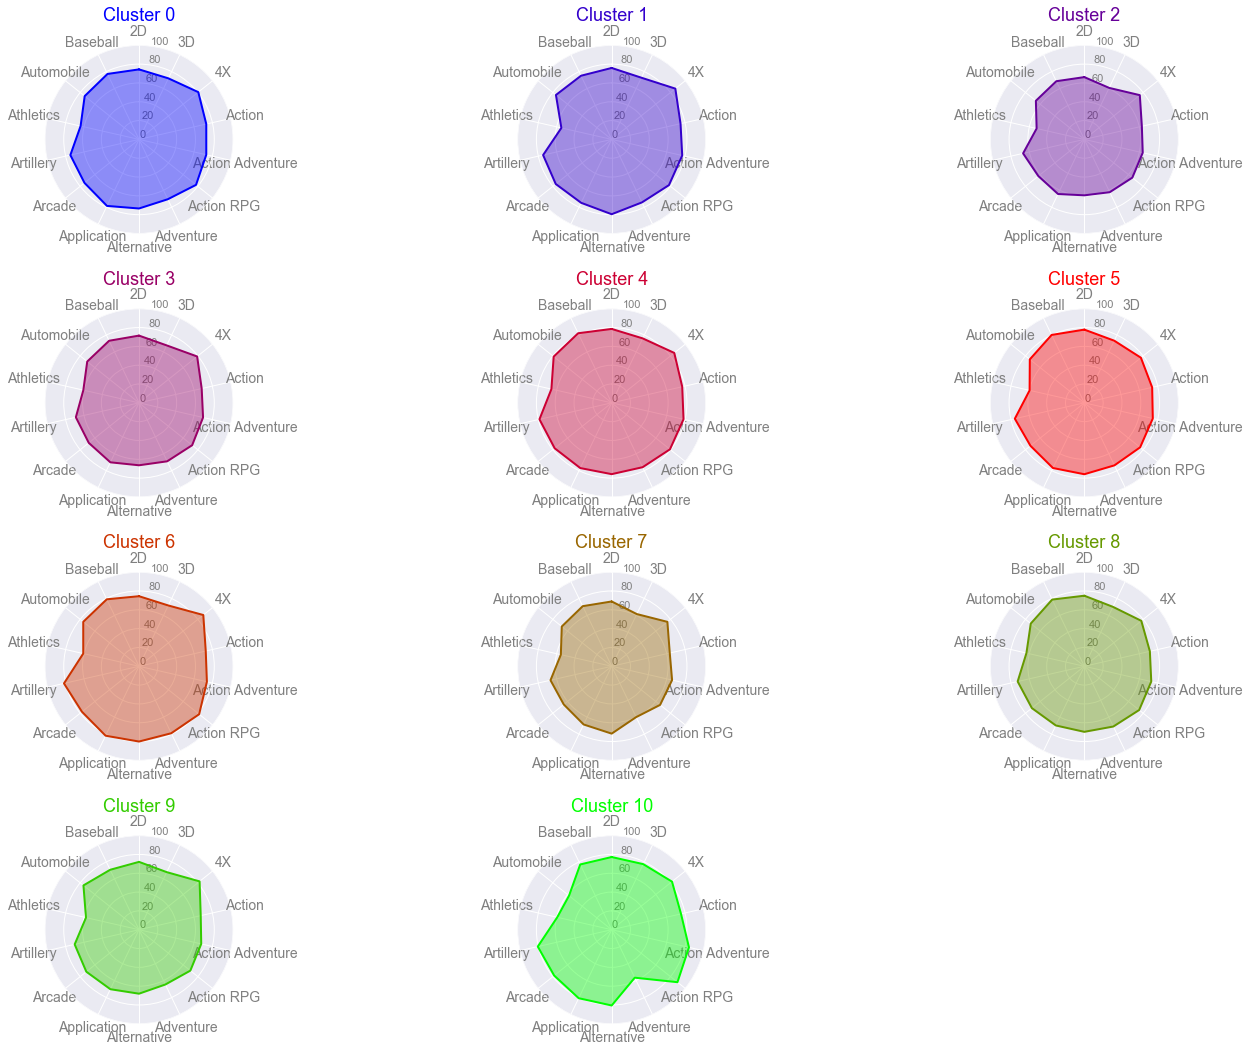

In [34]:
ncols = 3
nrows = math.ceil(len(radar.index)/ncols)
my_palette = plt.cm.get_cmap("brg", len(radar.index))

plt.figure(figsize=(24,18))
plt.subplots_adjust(hspace=0.4)

for index, row in radar.iloc[:, :15].iterrows():
    ax = plt.subplot(nrows, ncols, index + 1, polar=True)
    make_spider(ax, row, color=my_palette(index))

### 6.2 Predictions
Now that the model has been fitted with the training data, we can start predicting what clusters the users belong in our test data.

In [35]:
predictions = clusterer.predict(scaled_test_matrix)
predictions

array([3, 0, 4, 4, 0, 3, 5, 4, 4, 8, 0, 4, 4, 5, 5, 0, 3, 5, 4, 1, 4, 8,
       9, 8, 0, 4, 8, 3, 3, 8, 3, 3, 8, 8, 8, 4, 8, 2, 7, 8, 8, 3, 3, 5,
       0, 4, 4, 8, 8, 3, 4, 8, 8, 8, 0, 5, 0, 8, 0, 8, 0, 3, 8, 0, 5, 0,
       8, 8, 8, 8, 4, 4, 8, 8, 3, 3, 4, 5, 4, 5, 5, 0, 4, 0, 8, 0, 5, 5,
       4, 0, 4, 0, 8, 3, 8, 0, 3, 5, 1, 5, 5, 4, 5, 5, 0, 0, 3, 4, 5, 3,
       8, 3, 5, 1, 4, 3, 1, 0, 5, 4, 8, 8, 3, 4, 8, 4, 5, 8, 4, 8, 5, 0,
       4, 4, 8, 4, 5, 4, 4, 8, 4, 2, 0, 4, 0, 0, 5, 8, 0, 8])

In [36]:
test_matrix['cluster'] = predictions
test = test.merge(test_matrix.reset_index()[['review_critic', 'cluster']])

And create a single large ratings dataset with all the clusters registered in a column.

In [38]:
ratings = pd.concat([test, train])

## 7.  ✅ Model validation
Now that we now what clusters the test users belong to, we can start comparing the average cluster score with the actual review score given by the review critic. The smaller the difference, the better the model is performing.

### 7.1 Calculating the recommendation score.

In [39]:
test_scores = test.groupby(['cluster', 'title', 'platform']).mean().reset_index()
test_scores.rename(inplace=True, columns={'meta_score': 'recommendation_score'})
test = pd.merge(test, test_scores)
test.sample(10, random_state=42)

,title,platform,meta_score,review_critic,cluster,recommendation_score
89029,Resident Evil 0: HD Remaster,PlayStation 4,75.0,PSX Extreme,5,73.333333
19108,SoulCalibur V,PlayStation 3,80.0,Digital Spy,8,81.100000
71867,Shin Megami Tensei: Devil Summoner - Raidou Ku...,PlayStation 2,85.0,Digital Entertainment News,3,83.333333
111332,Yoshi's New Island,3DS,50.0,Nintendo Life,0,50.000000
93862,TimeSplitters: Future Perfect,Xbox,91.0,Xbox Solution,4,89.750000
116009,Fortune Street,Wii,70.0,Meristation,5,70.000000
32296,College Hoops 2K6,Xbox 360,70.0,DarkStation,8,72.000000
45512,Metal Arms: Glitch in the System,Xbox,84.0,Armchair Empire,0,81.375000
73025,Final Fantasy,PSP,57.0,Digital Entertainment News,3,63.500000
15818,FIFA Soccer 2003,PC,70.0,IGN,8,80.500000


### 7.2 Mean aboslute/squared error

In [40]:
MSE = mean_squared_error(test['meta_score'], test['recommendation_score'])
MAE = mean_absolute_error(test['meta_score'], test['recommendation_score'])

print(f"Mean Squared Error: {MSE}")
print(f"Mean Absolute Error: {MAE}")

Mean Squared Error: 51.115820919476995
Mean Absolute Error: 4.600827360720321


### 7.3 Accuraccy of the predictions

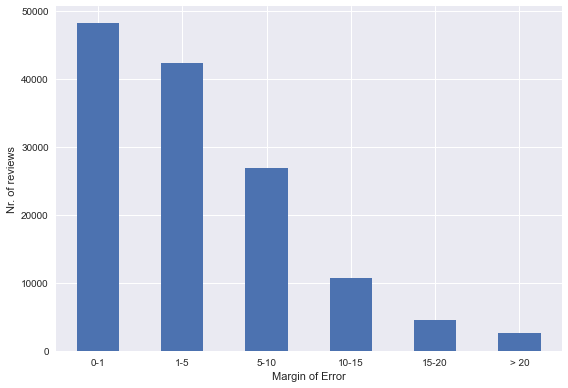

In [41]:
test['Error'] = abs(test['meta_score'] - test['recommendation_score'])

test['ErrorType'] = 0
test.loc[test['Error'] > 1, 'ErrorType'] += 1
test.loc[test['Error'] > 5, 'ErrorType'] += 1
test.loc[test['Error'] > 10, 'ErrorType'] += 1
test.loc[test['Error'] > 15, 'ErrorType'] += 1
test.loc[test['Error'] > 20, 'ErrorType'] += 1

test.groupby(['ErrorType']).size().plot.bar()
plt.xticks(range(0, 6), labels=["0-1", "1-5", "5-10", "10-15", "15-20", "> 20"], rotation=0)
plt.xlabel('Margin of Error')
plt.ylabel('Nr. of reviews')
plt.tight_layout()
plt.show()

Most of the predictions seem to be correct with them not being more than 5 out of 100 ratings off from the actual score given by the reviewer. However, this type of measurement is not completely indicative of the actual accuracy of the model, because if each user was put in its own cluster (which is possible with a high enough `K_CLUSTER` value, it would essentially mean that all the predictions are amost 100% correct, but you won’t really have any recommendations as the amount of critics in the cluster is very small. Therefore, it’s best to look if the actual recommendations themselves are explainable.

## 📊 8. Recommendations
After determining which clusters the users belong to, we can start collecting all the ratings of the critics that belong to the same cluster. We no longer care about the opinions of the reviews that belong to other clusters as they have different intrests compared to us. Let's pick the first cluster and spectate the top recommendations.

In [44]:
cluster = ratings[ratings['cluster'] == 0]
cluster = cluster[cluster['platform'].isin(SUPPORTED_PLATFORMS)]

In [45]:
cluster_ratings = cluster.groupby(['platform', 'title']).mean().reset_index()
cluster_ratings.sort_values(['meta_score'], inplace=True, ascending=False)
cluster_ratings.head(20)

,platform,title,meta_score,cluster
167,Switch,Celeste,100.000000,0
93,Switch,Bayonetta + Bayonetta 2,100.000000,0
428,Switch,Horace,100.000000,0
1033,Switch,The Legend of Zelda: Breath of the Wild,99.000000,0
404,Switch,Hades,98.000000,0
960,Switch,Super Mario Odyssey,97.200000,0
557,Switch,Mario Kart 8 Deluxe,97.000000,0
427,Switch,Hollow Knight,96.250000,0
969,Switch,Super Smash Bros. Ultimate,95.500000,0
957,Switch,Super Mario 3D World + Bowser's Fury,95.166667,0


Not bad suggestions at all, but some of these are questionable at best. *'Horace'*, *'Axiom Verge'* and *'Divinity: Original Sin II'* are games I've certainly never heard of, so why are they this high up on the list?

In [46]:
cluster_sizes = cluster.groupby(['platform', 'title']).agg({'title':'size', 'meta_score':'mean'})
cluster_sizes = cluster_sizes.rename(columns={'title':'count'}).reset_index()
cluster_sizes.sort_values(['count'], inplace=True, ascending=False)
cluster_sizes.head(20)

,platform,title,count,meta_score
969,Switch,Super Smash Bros. Ultimate,8,95.500000
712,Switch,Paper Mario: The Origami King,7,83.857143
746,Switch,"Pokemon: Let's Go, Pikachu!",7,82.285714
542,Switch,Luigi's Mansion 3,7,90.142857
147,Switch,Captain Toad: Treasure Tracker,7,83.714286
959,Switch,Super Mario Maker 2,7,92.142857
502,Switch,Kirby Star Allies,7,78.285714
513,Switch,LIMBO,7,82.142857
45,Switch,Animal Crossing: New Horizons,6,94.166667
742,Switch,Pokemon Sword / Shield Dual Pack,6,84.000000


When we start sorting on the total amount of reviews for a game, the suggestions make a lot more sense to me personally. Most of these games I've actually seen/played or at the least heard of. So, we need to find a balance between the average review score and the total amount of reviews written for that game. If we only have one review for a game in the cluster that has scored really high it's probably still not a good sugesstion for users to play. We need some kind of way to "punish" games that don't have a lot of recommendations.

We want to scale down the scores by the number of reviews we have. The higher we get to 'infinity' the closer we want to get to the actual mean score. I think the desired effect is best explained with a simple table that gives you a rough idea of what we want to achieve.

|  X  |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |   9   |
| --- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- |
|  Y  |  0.5  | 0.667 | 0.75  |  0.8  | 0.83  | 0.857 | 0.875 | 0.888 |  0.9  |

Here we can see that as X grows, the Y increases as well, but the effect weakens over time. Y will be the multiplication factor that we apply on the `meta_score`. If we have one review, the score gets divided in half, if we have two reviews it gets divided by 2/3 and if we have three reviews, the score gets divided by 3/4 and so forth.

The formula that belongs to the table above is the following:<br>
`Y = (X)/(X+1) * score`

The strength of the punishment is decided by the magic number `PENALIZER_STRENGTH`. If we were to increase this number, the punishments get stronger and if we were to lower this number the punishments become weaker. In this case I want this effect to be pretty strong because I'd like to avoid recommending possible poor games over not recommending good games! Now let's apply this formula to our recommendations and see the results.

You can experiment with the formula in [WolframAlpha](https://www.wolframalpha.com/input/?i=x%2F%28x%2B1%29+from+0+to+10) or by playing with the settings.

In [49]:
weight = lambda x: (x['count'])/(x['count']+PENALIZER_STRENGTH) * x['meta_score']

In [50]:
recommendations = pd.DataFrame(cluster_sizes)
recommendations['recommendation_score'] = weight(recommendations)
recommendations.sort_values(['recommendation_score'], ascending=False).head(20)

,platform,title,count,meta_score,recommendation_score
969,Switch,Super Smash Bros. Ultimate,8,95.500000,84.888889
1033,Switch,The Legend of Zelda: Breath of the Wild,5,99.000000,82.500000
404,Switch,Hades,5,98.000000,81.666667
957,Switch,Super Mario 3D World + Bowser's Fury,6,95.166667,81.571429
960,Switch,Super Mario Odyssey,5,97.200000,81.000000
557,Switch,Mario Kart 8 Deluxe,5,97.000000,80.833333
45,Switch,Animal Crossing: New Horizons,6,94.166667,80.714286
959,Switch,Super Mario Maker 2,7,92.142857,80.625000
167,Switch,Celeste,4,100.000000,80.000000
231,Switch,Dead Cells,6,92.166667,79.000000


And there we have it, the recommendations based on onces personal preference! Most of these games are the must plays of the system so it makes sense to have them at the top. Once the collection of the user grows, these can be filtered out and the more obscure titles start to become more visible to the user.

## 📝 9. Conclusion

In the beginning of the document, we've started with examining the correlations between the different genres of videogames and their scorings. After finding some interesting correlations in some of them we started to experiment with using KMeans to compare two genres with each other, namely action and adventure. We noticed that the more clusters we added, the more similar the taste of each cluster blends in with the other clusters. Due to the difficulty of measuring how many clusters we needed we utilized the elbow method (along with the silhouette score) to look for the optimal value for the number of clusters.

After confirming that there was relation between the critics and gernes and have a basic understanding on how KMeans would operate we went ahead an applied it to all genres. For preparations we decided to filter out all the data that we didn't want/need and imputed the missing values using different strategies (drop, mean, zeros and neutral and kNN). We applied some StandardScaling to avoid miscalculations between the distances of data. After that, we compared the average score of the cluster with the actual review scores that the test users gave to the reviews to see if the users were placed in the cluster they belonged into. Most of the ratings were only off by 5 out of 100 points, which seemed a little suspicious to me so I decided to also validate if the top recommendations actually made sense themselves.

We started to see some weired games pop up at the top that I certainly never heard of. We decided to panalize these games using the `PENALIZER_STRENGTH` variable, which punishes games that don't have a lot of reviews in the cluster as their 'average' is kind of skewed.

Possible ways to improve the model:
 * [A different dataset](https://www.metacritic.com/feature/game-critic-scores-vs-user-reviews) that contains information about users, not critics! In hindsight, critics try to judge games objectively resulting in similar scores of games that differ might differ wildly in content. User behavior is more biased, which is the kind of behavior that we might need to improve the recommendations to feel more personal.
 * Look at the correlation between games instead of genres. This might result in more accurate predictions on a per game basis.
 
All in all, these recommendations are not too bad!